In [1]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import scipy.io
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
device = 'gpu' 

In [2]:
import scipy.io

mat = scipy.io.loadmat('/kaggle/input/homework7/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}

cars_meta = scipy.io.loadmat('/kaggle/input/homework7/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Train аугментации

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    
    # Случайно вырезаем квадратный фрагмент 224x224 из изображения 256x256
    torchvision.transforms.RandomCrop(224),
    # С вероятностью 50% отражаем изображение по горизонтали
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # Случайно изменяем яркость, контраст и насыщенность цвета в пределах ±20% 
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TripletDataset(Dataset): # Данные в формате триплетов
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = np.array(labels)
        self.transform = transform
        self.label_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)
        self.labels_set = set(self.labels)

    def __getitem__(self, index):
        anchor_path = self.image_paths[index]
        anchor_label = self.labels[index]
        
        # Positive: случайное изображение с тем же классом 
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        
        # Negative: случайное изображение с другим классом
        negative_label = np.random.choice(list(self.labels_set - {anchor_label}))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        
        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(self.image_paths[positive_index]).convert("RGB")
        negative_img = Image.open(self.image_paths[negative_index]).convert("RGB")
        
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.image_paths)

In [6]:

items = list(fname_to_class.items())
random.shuffle(items)

split_idx = int(len(items) * 0.8)
train_items = items[:split_idx]   
val_items = items[split_idx:]     


TRAIN_IMG_DIR = '/kaggle/input/homework7cars/cars_train/cars_train'
TEST_IMG_DIR = '/kaggle/input/homework7cars/cars_test/cars_test'

train_paths = [os.path.join(TRAIN_IMG_DIR, fname) for fname, _ in train_items]
train_labels = [label for _, label in train_items] 

val_paths = [os.path.join(TEST_IMG_DIR, fname) for fname, _ in val_items]
val_labels = [label for _, label in val_items]      

In [7]:
train_dataset = TripletDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = TripletDataset(val_paths, val_labels, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
new_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

In [8]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    # Целт лосса сделать dist(anchor, positive) < dist(anchor, negative) - margin 
    dist_pos = torch.nn.functional.pairwise_distance(anchor, positive, p=2)
    dist_neg = torch.nn.functional.pairwise_distance(anchor, negative, p=2)
    loss = torch.relu(dist_pos - dist_neg + margin)
    return loss.mean()

In [9]:
from timm.scheduler import TanhLRScheduler
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from timm.scheduler import TanhLRScheduler
from lightning.pytorch.callbacks import LearningRateMonitor
from torchvision.models import resnet50
class CarEmbedder(pl.LightningModule):
    def __init__(self, embedding_size=512, learning_rate=3e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.embedding_size = embedding_size
        
        # Загружаем EfficientNet-B0 с предобученными весами
        backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Убираем классификатор
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        
        # Размер входа в классификатор EfficientNet-B0 = 1280
        self.embedding_head = nn.Sequential(
            nn.Linear(1280, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )
        
        self.save_hyperparameters()

    def forward(self, x):
        features = self.backbone(x)  # [B, 1280, 1, 1]
        features = features.flatten(1)  # [B, 1280]
        embeddings = self.embedding_head(features)  # [B, embedding_size]
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        return embeddings

    def training_step(self, batch, batch_idx):
        anchor_img, pos_img, neg_img = batch
        emb_a = self(anchor_img)
        emb_p = self(pos_img)
        emb_n = self(neg_img)
        
        loss = triplet_loss(emb_a, emb_p, emb_n, margin=0.2)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [10]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
pl_model = CarEmbedder(embedding_size=512, learning_rate=3e-4)

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss', 
    mode='min',
    save_top_k=1,
    filename='best-embedder-{epoch}-{train_loss:.4f}'
)

early_stopping = EarlyStopping(
    monitor="train_loss",
    mode="min",
    patience = 5
)

lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    callbacks=[checkpoint_callback, early_stopping, lr_monitor]
)

# Запуск обучения
trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=new_val_loader)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
2025-10-19 18:12:57.577995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760897577.599869     129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760897577.607410     129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11

Training: |          | 0/? [00:00<?, ?it/s]

In [11]:
import numpy as np

def precision_at_k(query_labels, topk_labels, k=10): # Precision@k

    query_labels = np.array(query_labels)
    topk_labels = np.array(topk_labels)
    
    # совпадает ли класс
    relevant = (topk_labels == query_labels[:, None]) 
    
    # число релевантных в top-k / k
    precision = relevant.sum(axis=1) / k 
    return precision.mean()


def recall_at_k(query_labels, topk_labels, k=10): # Recall@k
    
    query_labels = np.array(query_labels)
    topk_labels = np.array(topk_labels)
    
    relevant = (topk_labels == query_labels[:, None])  
    recall = (relevant.sum(axis=1) > 0).astype(float)  
    return recall.mean()


def average_precision_at_k(query_label, topk_labels, k=10):
    
    topk_labels = np.array(topk_labels)
    relevant = (topk_labels == query_label).astype(int)
    
    if relevant.sum() == 0:
        return 0.0
    
    # precision@i для каждой позиции i 
    ap = 0.0
    num_relevant = 0
    for i in range(k):
        if relevant[i]:
            num_relevant += 1
            precision_at_i = num_relevant / (i + 1)
            ap += precision_at_i
    return ap / relevant.sum()


def map_at_k(query_labels, topk_labels, k=10): # mAP

    query_labels = np.array(query_labels)
    topk_labels = np.array(topk_labels)
    
    aps = []
    for i in range(len(query_labels)):
        ap = average_precision_at_k(query_labels[i], topk_labels[i], k=k)
        aps.append(ap)
    return np.mean(aps)

In [12]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class SimpleCarDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [13]:

test_paths = [os.path.join(TRAIN_IMG_DIR, f) for f in fname_to_class.keys()]
test_labels = list(fname_to_class.values())

test_dataset = SimpleCarDataset(test_paths, test_labels, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [14]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            emb = model(imgs)  # [B, D]
            embeddings.append(emb.cpu())
            labels.append(lbls)
    embeddings = torch.cat(embeddings).numpy()  
    labels = torch.cat(labels).numpy()          
    return embeddings, labels

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pl_model.to(device)

embeddings, labels = extract_embeddings(pl_model, test_loader, device)
print("Embeddings shape:", embeddings.shape)
print("Labels shape:", labels.shape)

Embeddings shape: (8144, 512)
Labels shape: (8144,)


In [18]:
import faiss

# Нормализуем эмбеддинги 
faiss.normalize_L2(embeddings)
# Создаём индекс
index = faiss.IndexFlatIP(embeddings.shape[1])  
index.add(embeddings)
# Ищем top-(k+1), потому что первым соседом будет собственно само изображение
k = 100
distances, indices = index.search(embeddings, k + 1)  # [N, k+1]

topk_indices = []
for i in range(len(embeddings)):
    neighbors = indices[i]
    # Убираем i из списка соседей
    neighbors = neighbors[neighbors != i]
    topk_indices.append(neighbors[:k])
topk_indices = np.array(topk_indices)  # [N, k]

# Получаем метки соседей
topk_labels = labels[topk_indices]  # [N, k]
query_labels = labels               # [N]

In [19]:
# Проверка реализованных метрик

k = 100
p_at_k = precision_at_k(query_labels, topk_labels, k=k)
r_at_k = recall_at_k(query_labels, topk_labels, k=k)
map_at_k_val = map_at_k(query_labels, topk_labels, k=k)

print(f"Precision@{k}: {p_at_k:.4f}")
print(f"Recall@{k}: {r_at_k:.4f}")
print(f"mAP@{k}: {map_at_k_val:.4f}")


Precision@100: 0.2066
Recall@100: 0.9875
mAP@100: 0.4030


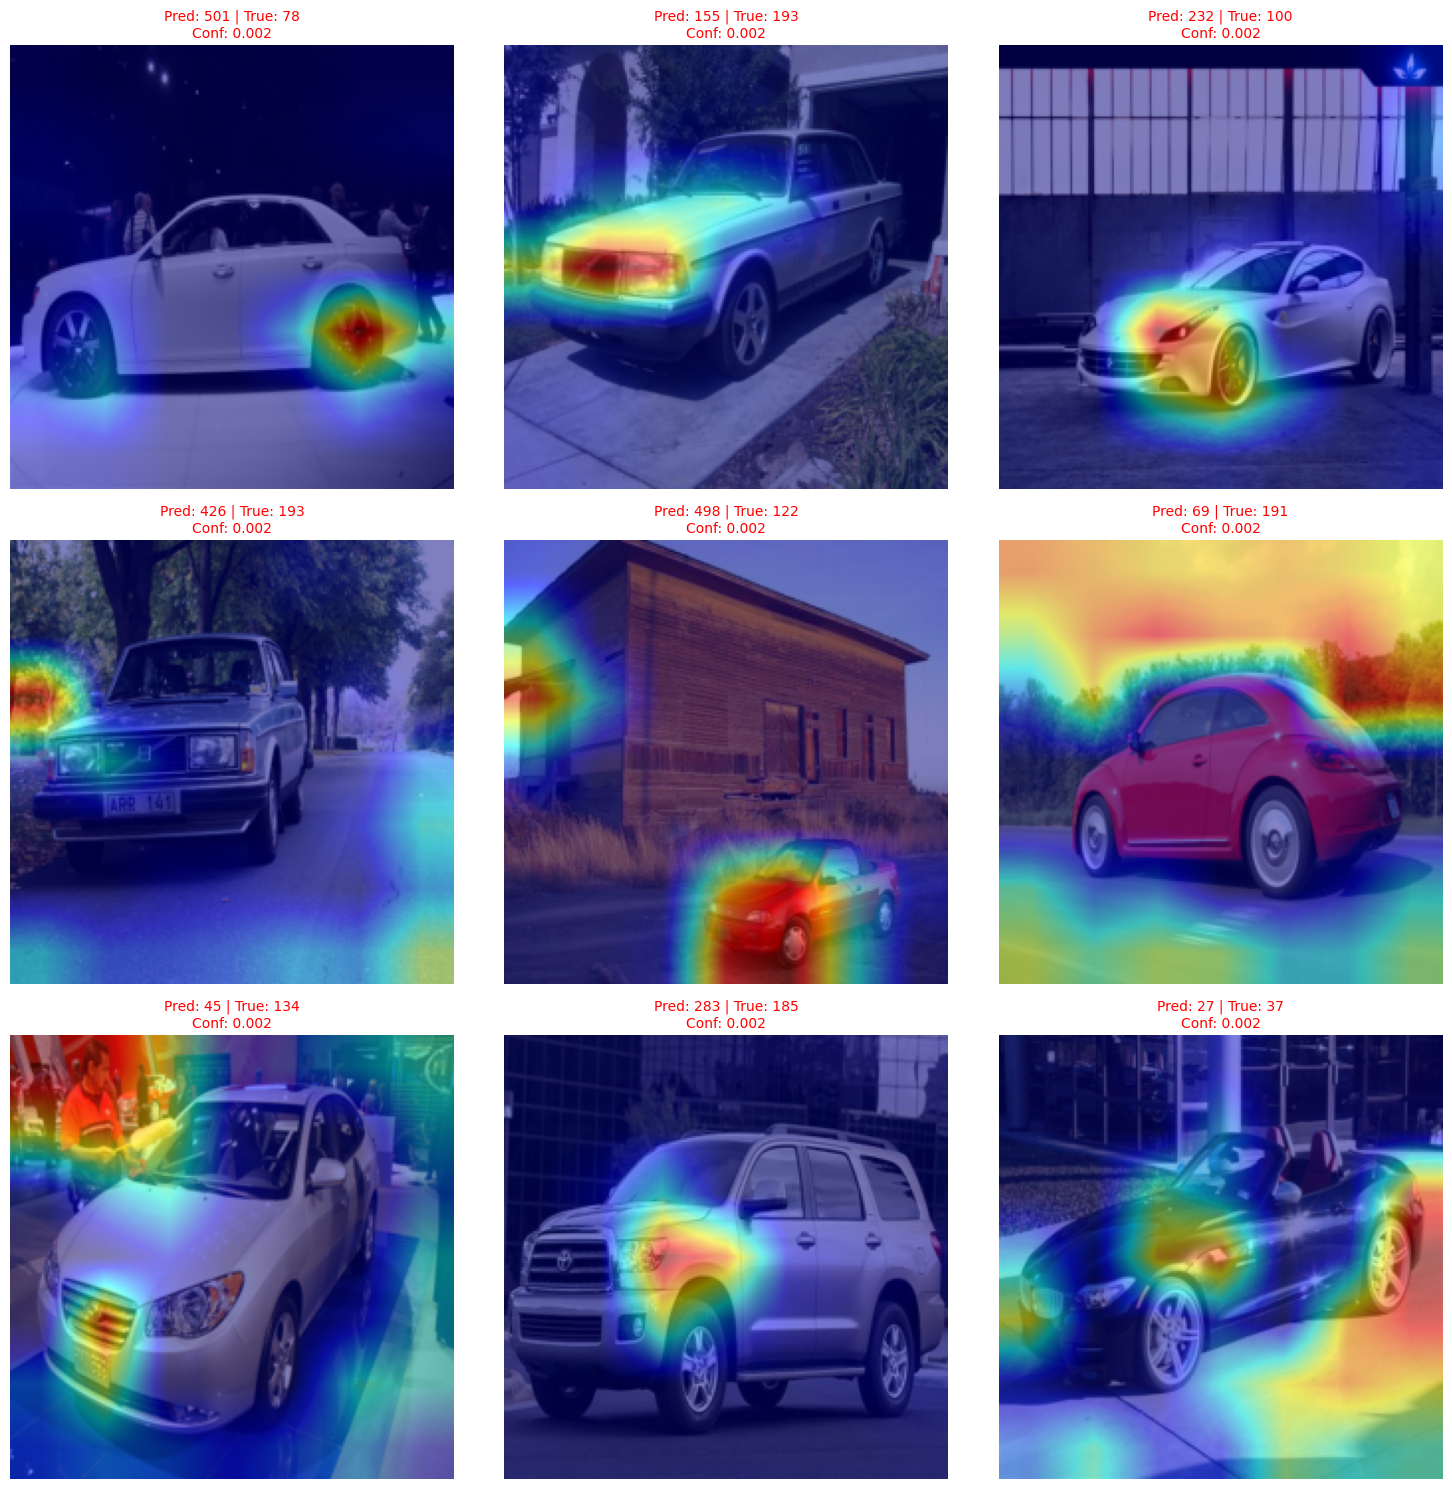

In [27]:
# Демонстрация GradCAM

import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import random

model = pl_model.eval().to(device)

target_layer = model.backbone[-2]

def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().cpu().numpy().transpose(1, 2, 0)
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def get_prediction(model, input_tensor):
    with torch.no_grad():
        embeddings = model(input_tensor.unsqueeze(0))
        if embeddings.shape[1] > 1:  
            probabilities = torch.softmax(embeddings, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = torch.max(probabilities).item()
        else:  
            predicted_class = (embeddings > 0).int().item()
            confidence = torch.sigmoid(embeddings).item() if embeddings.shape[1] == 1 else 0.5
    return predicted_class, confidence

def gradcam_for_embedding(model, input_tensor, target_layer, embedding_component=0):
    model.eval()
    
    def forward_fn(x):
        emb = model(x)
        return emb[:, embedding_component].sum()

    cam = GradCAM(
        model=model,
        target_layers=[target_layer]
    )
    
    grayscale_cam = cam(
        input_tensor=input_tensor.unsqueeze(0),
        targets=None
    )
    return grayscale_cam[0, :]

# Собираем 9 разных изображений
images_data = []
used_indices = set()

# Проходим по датасету, чтобы найти разные изображения
for batch_idx, (batch_images, batch_labels) in enumerate(test_loader):
    for img_idx in range(len(batch_images)):
        if len(images_data) >= 9:
            break
            
        # Берем случайное изображение из батча
        random_idx = random.randint(0, len(batch_images) - 1)
        image_tensor = batch_images[random_idx]
        true_label = batch_labels[random_idx].item()
        
        # Проверяем, не использовали ли мы уже это изображение
        image_hash = hash(image_tensor.sum().item())
        if image_hash not in used_indices:
            images_data.append((image_tensor, true_label))
            used_indices.add(image_hash)
    
    if len(images_data) >= 9:
        break

# Если не набрали 9 уникальных изображений, дополняем случайными
if len(images_data) < 9:
    remaining = 9 - len(images_data)
    all_images = []
    for batch_images, batch_labels in test_loader:
        all_images.extend(list(zip(batch_images, batch_labels)))
    
    random.shuffle(all_images)
    for image_tensor, true_label in all_images:
        if len(images_data) >= 9:
            break
        image_hash = hash(image_tensor.sum().item())
        if image_hash not in used_indices:
            images_data.append((image_tensor[0] if isinstance(image_tensor, list) else image_tensor, 
                              true_label.item() if isinstance(true_label, torch.Tensor) else true_label))
            used_indices.add(image_hash)

# Создаем сетку 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, (image_tensor, true_label) in enumerate(images_data):
    if idx >= 9:
        break
        
    rgb_img = denormalize(image_tensor)
    
    predicted_class, confidence = get_prediction(model, image_tensor.to(device))
    
    cam_map = gradcam_for_embedding(
        model=model,
        input_tensor=image_tensor.to(device),
        target_layer=target_layer,
        embedding_component=0
    )
    
    visualization = show_cam_on_image(rgb_img, cam_map, use_rgb=True)
    
    axes[idx].imshow(visualization)
    
    color = 'green' if predicted_class == true_label else 'red'
    axes[idx].set_title(f'Pred: {predicted_class} | True: {true_label}\nConf: {confidence:.3f}', 
                       color=color, fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
